In [1]:
import sys
sys.path.append("../")
import os
from rdkit import Chem
from io import BytesIO
import multiprocessing
from multiprocessing import Pool, cpu_count

In [2]:
from molNet.featurizer.molecule_featurizer import (
    molecule_mol_wt,
    molecule_num_atoms,
    molecule_num_rings,
    molecule_asphericity,
)
from molNet.utils.mol.properties import has_confomers
from molNet.featurizer import molecule_featurizer
from molNet.featurizer.molecule_featurizer import *

to_ecdf={
    "molecule_mol_wt":molecule_mol_wt,
    "molecule_num_atoms":molecule_num_atoms,
    "molecule_num_rings":molecule_num_rings,
    "molecule_asphericity":molecule_asphericity,
    "molecule_autocorr2d":molecule_autocorr2d 
        }

for fs,_f in molecule_featurizer._available_featurizer.items():
    if fs.startswith("molecule_"):
        to_ecdf[fs]=_f

In [3]:
THREAD_COUND=max(1,int(cpu_count()-2))
DATA_FOLDER="/media/julian/ex1ext4_1/temp/"
MOL_FOLDER=os.path.join(DATA_FOLDER,"CID-MOLES")
MOLPROP_FOLDER=os.path.join(DATA_FOLDER,"CID-PROPS")

os.makedirs(MOL_FOLDER,exist_ok=True)
os.makedirs(MOLPROP_FOLDER,exist_ok=True)

In [4]:
mol_files=np.array([os.path.join(MOL_FOLDER,f)for f in os.listdir(MOL_FOLDER) if f.endswith(".mol")])
np.random.shuffle(mol_files)

In [5]:
def load_mol_file(path):
    with open(path,"rb") as f:
        mol = Chem.Mol(f.read())
    return mol

def get_mol_data_dict(mol,skip_errors=False):
    d={}
    for c,f in to_ecdf.items():
        try:
            v=f(mol)
            d[c]=v
        except Exception as e:
            if not skip_errors:
                raise e
    return d

def determine_size(n_samples=100):
    samples=[]
    for mf in mol_files:
        try:
            mol = load_mol_file(mf)
            #display(mol)
        except FileNotFoundError:
            continue
        if len(Chem.rdmolops.GetMolFrags(mol)) > 1:
            continue       
        try:
            d=get_mol_data_dict(mol)
        except Exception as e:
            
            continue
            
        file_obj=BytesIO()
        np.savez(file_obj, **d)
        s=len(file_obj.getvalue())
        samples.append(s)
        if len(samples)>=n_samples:
            break
    print(np.min(samples),np.median(samples),np.mean(samples),np.max(samples))
    return int(np.median(samples))

In [6]:
#datasize=determine_size()
datasize=157066
datasize

157066

In [7]:
def get_mol_data_dict(mol,skip_errors=False):
    d={}
    for c,f in to_ecdf.items():
        try:
            v=f(mol)
            d[c]=v
        except Exception as e:
            if not skip_errors:
                raise e
    return d

def molfile_to_prop_file(molfile,propfile,target_size=None,ignore_errors=True,skip_errors=False, skip_fragmented=True):
    if os.path.exists(propfile):
        if target_size is None:
            return True
        if os.path.getsize(propfile) == target_size:
            return True
            
    mol = load_mol_file(molfile)
    
    if skip_fragmented:
        if len(Chem.rdmolops.GetMolFrags(mol)) > 1:
            return False 
    
   
    try:
        d=get_mol_data_dict(mol,skip_errors=skip_errors)
    except Exception as e:
        if ignore_errors:
            return False
        else:
            raise e

    with open(propfile,"w+b") as f:
        np.savez(f, **d)
    return True

def iter_mol_props_file(molfile,target_size=None):
    datafile=os.path.join(MOLPROP_FOLDER,os.path.basename(molfile).replace(".mol",".mdt"))
    
    #print(molfile,datafile)
    ex=None
    try:
        molfile_to_prop_file(
                    molfile=molfile,
                    propfile = datafile,
                    target_size=target_size,
                    ignore_errors=False,
                )
    except Exception as e:
            stre=str(e)
            if stre.startswith("ERROR: No Gasteiger Partial Charge"):
                ex=e
            elif stre.startswith("too few atoms"):
                    ex=e
            elif stre.startswith("numStereoCenters called without stereo being assigned"):
                try:
                    os.remove(molfile)
                except:pass
                ex=e
            elif stre.startswith("numUnspecifiedStereoCenters called without stereo being assigned"):
                try:
                    os.remove(molfile)
                except:pass
                ex=e
            elif stre.startswith("Can't kekulize mol"):
                try:
                    os.remove(molfile)
                except:pass
                ex=e
            elif stre.startswith("Explicit valence for atom"):
                try:
                    os.remove(molfile)
                except:pass
                ex=e
            elif stre.startswith("Bad pickle format"):
                try:
                    os.remove(molfile)
                except:pass
                ex=e
            else:
                print(stre)
    if ex is not None:
        return ex
    return True

In [ ]:
def _iter_mol_props_file(fs):
    for f in fs:
        iter_mol_props_file(f,target_size=datasize)

with Pool(processes=THREAD_COUND) as pool:
    res = pool.map(_iter_mol_props_file, np.array_split(mol_files,THREAD_COUND))

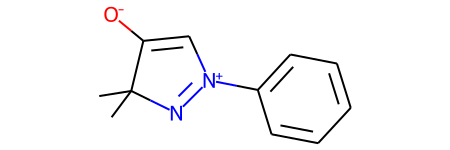

In [61]:
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot
from molNet.featurizer.featurizer import OneHotFeaturizer


In [48]:
d=np.zeros((400000,len(atom_symbol_one_hot)))
i=0
j=0
jf=d.shape[0]
while True:
    for atom in load_mol_file(mol_files[i]).GetAtoms():
        d[j]=atom_symbol_one_hot(atom)
        j+=1
        if j>=jf:
            break
    print(j,end="\r")
    i+=1
    if j>=jf:
        break
    

In [65]:
dsum0=d.sum(0).astype(int)
dict(zip(
    np.array(atom_symbol_one_hot.possible_values)[dsum0>d.shape[0]/i],
    dsum0[dsum0>d.shape[0]/i]/i
)),np.array(atom_symbol_one_hot.possible_values)[dsum0>d.shape[0]/i]

({'O': 2.7449206973391007,
  'Si': 0.014877441342246691,
  'Na': 0.003408048236990431,
  'H': 0.008978896316686328,
  'P': 0.024052955826451696,
  'F': 0.42771005374229915,
  'S': 0.3685935247083497,
  'C': 19.523397561934722,
  'Cl': 0.23050203172106437,
  'N': 2.7477388910735354,
  'B': 0.005439769301350111,
  'Br': 0.07871280639664438,
  'I': 0.02365971949141434},
 array(['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br',
        'I'], dtype=object))

In [77]:
def _get_atom_symbol(atom):
    return atom.GetSymbol()

atom_symbol_hcnopsclbr_one_hot = OneHotFeaturizer(
    possible_values=['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br','I',None],
    pre_featurize=_get_atom_symbol,
    name="atom_symbol_one_hot",
)

d2=np.zeros((400000,len(atom_symbol_hcnopsclbr_one_hot)))
i2=0
j2=0
jf2=d.shape[0]
while True:
    for atom in load_mol_file(mol_files[i2]).GetAtoms():
        d2[j2]=atom_symbol_hcnopsclbr_one_hot(atom)
        j2+=1
        if j2>=jf2:
            break
    print(j2,end="\r")
    i2+=1
    if j2>=jf2:
        break
    

In [83]:
dsum02=d2.sum(0).astype(int)
dict(zip(
    np.array(atom_symbol_hcnopsclbr_one_hot.possible_values),
    dsum02/i2
))

{'O': 2.7449206973391007,
 'Si': 0.014877441342246691,
 'Na': 0.003408048236990431,
 'H': 0.008978896316686328,
 'P': 0.024052955826451696,
 'F': 0.42771005374229915,
 'S': 0.3685935247083497,
 'C': 19.523397561934722,
 'Cl': 0.23050203172106437,
 'N': 2.7477388910735354,
 'B': 0.005439769301350111,
 'Br': 0.07871280639664438,
 'I': 0.02365971949141434,
 None: 0.013763271726307511}

In [79]:
dsum02

array([ 41882,    227,     52,    137,    367,   6526,   5624, 297888,
         3517,  41925,     83,   1201,    361,    210])